# RLLAB setup scripts for google colab
Install packages with compatible versions

In [0]:
!apt-get -qq install -y xvfb python-opengl > /dev/null 2>&1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg > /dev/null

In [0]:
!pip install -q path.py
!pip install -q pyprind
!pip install -q cached_property
!pip install -q gym==0.7.4
!pip install -q theano==0.8.2
!pip install -q git+https://github.com/neocxi/Lasagne.git@484866cf8b38d878e92d521be445968531646bb8#egg=Lasagne
  
!pip install -q PyOpenGL piglet pyglet pyvirtualdisplay

In [0]:
!pip install box2d-py mako==1.0.7 Pygame JSAnimation imageio

In [0]:
!git clone https://github.com/kekim/rllab.git rllab-git

In [0]:
!cp -a ./rllab-git/* .

# DQN Plus on Acrobot (OpenAI Gym version)
**Important!**
Before running the following cell, make sure rllab is set up properly in your current runtime by executing codes in RLLAB setup scripts.

**1. Implement DQN Plus (DDQN w/ Prioritized Experience Replay) Algorithm**

- Import necessary packages
(Execute **once again** if you encounter an error)

In [0]:
########## DQN_Plus_GYM_ACROBOT_With_RUN_EXP_LITE ##########
from rllab.envs.gym_env import GymEnv
from dqn.policies.categorical_mlp_q_policy import CategoricalMlpQPolicy
from dqn.exploration_strategies.eps_greedy_strategy import EpsilonGreedyStrategy

from rllab.envs.normalized_env import normalize
from rllab.misc.instrument import run_experiment_lite
from rllab.q_functions.continuous_mlp_q_function import ContinuousMLPQFunction

import lasagne.nonlinearities as NL

from rllab.algos.base import RLAlgorithm
from rllab.misc.overrides import overrides
from rllab.misc import special
from rllab.misc import ext
from rllab.sampler import parallel_sampler
from rllab.plotter import plotter
from functools import partial
import rllab.misc.logger as logger
import theano.tensor as TT
import pickle as pickle
import numpy as np
import pyprind
import lasagne
from collections import deque
from rllab.algos.ddpg import parse_update_method#, SimpleReplayPool
from scipy.stats import rankdata

import random
from six.moves import xrange


- Implement Prioritized Replay Buffer

In [0]:
class ReplayBuffer(object):

    def __init__(self, max_size):
        self.max_size = max_size
        self.cur_size = 0
        self.buffer = {}
        self.init_length = 0

    def __len__(self):
        return self.cur_size

    def seed_buffer(self, episodes):
        self.init_length = len(episodes)
        self.add(episodes, np.ones(self.init_length))

    def add(self, episodes, *args):
        """Add episodes to buffer."""
        idx = 0
        while self.cur_size < self.max_size and idx < len(episodes):
            self.buffer[self.cur_size] = episodes[idx]
            self.cur_size += 1
            idx += 1

        if idx < len(episodes):
            remove_idxs = self.remove_n(len(episodes) - idx)
            for remove_idx in remove_idxs:
                self.buffer[remove_idx] = episodes[idx]
                idx += 1

        assert len(self.buffer) == self.cur_size

    def remove_n(self, n):
        """Get n items for removal."""
        # random removal
        idxs = random.sample(xrange(self.init_length, self.cur_size), n)
        return idxs

    def get_batch(self, n):
        """Get batch of episodes to train on."""
        # random batch
        idxs = random.sample(xrange(self.cur_size), n)
        return [self.buffer[idx] for idx in idxs], None

    def update_last_batch(self, delta):
        pass


class PrioritizedReplayBuffer(ReplayBuffer):

    def __init__(self, max_size, n_steps, alpha=0.6, beta=0.4,
                   eviction_strategy='fifo'):
        self.max_size = max_size
        self.alpha = alpha
        self.beta = beta
        self.beta_increment = (1.0-beta)/(n_steps-100.0)
        self.epsilon = 0.000001

        self.eviction_strategy = eviction_strategy
        assert self.eviction_strategy in ['rand', 'fifo', 'rank']
        
        self.remove_idx = 0

        self.cur_size = 0
        self.buffer = {}
        self.priorities = np.zeros(self.max_size)
        self.init_length = 0

    def __len__(self):
        return self.cur_size

    def add(self, episodes, new_idxs=None):
        """Add episodes to buffer."""
        if new_idxs is None:
            idx = 0
            new_idxs = []
            while self.cur_size < self.max_size and idx < len(episodes):
                self.buffer[self.cur_size] = episodes[idx]
                new_idxs.append(self.cur_size)
                self.cur_size += 1
                idx += 1

            if idx < len(episodes):
                remove_idxs = self.remove_n(len(episodes) - idx)
                for remove_idx in remove_idxs:
                    self.buffer[remove_idx] = episodes[idx]
                    new_idxs.append(remove_idx)
                    idx += 1
        else:
            assert len(new_idxs) == len(episodes)
            for new_idx, ep in zip(new_idxs, episodes):
                self.buffer[new_idx] = ep

        self.priorities[new_idxs] = np.max(self.priorities)#np.max([np.max(self.priorities), 0.000001])
        self.priorities[0:self.init_length] = np.max(
            self.priorities[self.init_length:])

        assert len(self.buffer) == self.cur_size
        return new_idxs

    def remove_n(self, n):
        """Get n items for removal."""
        assert self.init_length + n <= self.cur_size

        if self.eviction_strategy == 'rand':
            # random removal
            idxs = random.sample(xrange(self.init_length, self.cur_size), n)
        elif self.eviction_strategy == 'fifo':
            # overwrite elements in cyclical fashion
            idxs = [
                self.init_length +
                (self.remove_idx + i) % (self.max_size - self.init_length)
                for i in xrange(n)]
            self.remove_idx = idxs[-1] + 1 - self.init_length
        elif self.eviction_strategy == 'rank':
            # remove lowest-priority indices
            idxs = np.argpartition(self.priorities, n)[:n]

        return idxs

    # Experiment 2, Prob.1: Generate sampling distribution and weights in replay buffer
    ###################################################################################
    def sampling_distribution(self):
        # Add small constant to td-errors for numerical stability
        p = self.priorities[:self.cur_size] + self.epsilon

        # P(j) = (p_j)^alpha / sum_i[ (p_i)^alpha ]
        p = np.power(p, self.alpha)
        p = p / np.sum(p)

        # w_j = [N*P(j)]^beta / max_i[ [N*P(i)]^beta ]
        w = np.power(self.cur_size*p, (-1.0)*self.beta)
        w = w / np.max(w)

        # Annealing beta
        self.beta = np.min([1.0, self.beta+self.beta_increment])

        return p, w

    def priority_batch(self, n):
        # Get sampling distribtuion and corresponding weights of transitions.
        p, w = self.sampling_distribution()

        idxs = np.random.choice(self.cur_size, size=int(n), replace=False, p=p)
        self.last_batch = idxs
        # import pdb; pdb.set_trace()
        observations = np.array([self.buffer[idx][0] for idx in idxs])
        actions = np.array([self.buffer[idx][1] for idx in idxs])
        rewards = np.array([self.buffer[idx][2] for idx in idxs])
        next_observations = np.array([self.buffer[idx][3] for idx in idxs])
        terminals = np.array([self.buffer[idx][4] for idx in idxs])

        
        return [observations, actions, rewards, next_observations, terminals, w[idxs]]

    def update_last_batch(self, delta):
        """Update last batch idxs with new priority."""
        self.priorities[self.last_batch] = np.abs(delta)
        self.priorities[0:self.init_length] = np.max(
            self.priorities[self.init_length:])


- Implement DQN Plus (DDQN-based) algorithm

In [0]:
class DQN_PLUS(RLAlgorithm):
    """
    Deep Q Network
    """

    def __init__(
            self,
            env,
            policy,
            es,
            batch_size=32,
            alpha=0.6,
            beta=0.4,
            n_steps=8000000,
            min_pool_size=1000000,
            replay_pool_size=1000000,
            discount=0.99,
            policy_update_method='adam',
            policy_learning_rate=1e-3,
            target_model_update=10000,
            n_updates_per_sample=1,
            train_epoch_interval=10000,
            max_path_length=np.inf,
            n_eval_samples=5,
            delta_clip=np.inf,
            include_horizon_terminal_transitions=False,
            plot=False,
            pause_for_plot=False):
        """
        :param env: Environment
        :param policy: Policy
        :param qf: Q function
        :param es: Exploration strategy
        :param batch_size: Number of samples for each minibatch.
        :param n_epochs: Number of epochs. Policy will be evaluated after each epoch.
        :param epoch_length: How many timesteps for each epoch.
        :param min_pool_size: Minimum size of the pool to start training.
        :param replay_pool_size: Size of the experience replay pool.
        :param discount: Discount factor for the cumulative return.
        :param max_path_length: Discount factor for the cumulative return.
        :param qf_weight_decay: Weight decay factor for parameters of the Q function.
        :param qf_update_method: Online optimization method for training Q function.
        :param qf_learning_rate: Learning rate for training Q function.
        :param policy_weight_decay: Weight decay factor for parameters of the policy.
        :param policy_update_method: Online optimization method for training the policy.
        :param policy_learning_rate: Learning rate for training the policy.
        :param n_eval_samples: Number of samples (timesteps) for evaluating the policy.
        :param soft_target_tau: Interpolation parameter for doing the soft target update.
        :param n_updates_per_sample: Number of Q function and policy updates per new sample obtained
        :param scale_reward: The scaling factor applied to the rewards when training
        :param include_horizon_terminal_transitions: whether to include transitions with terminal=True because the
        horizon was reached. This might make the Q value back up less stable for certain tasks.
        :param plot: Whether to visualize the policy performance after each train_epoch_interval.
        :param pause_for_plot: Whether to pause before continuing when plotting.
        :return:
        """
        self.env = env
        self.policy = policy
        self.es = es
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta

        self.min_pool_size = min_pool_size
        self.replay_pool_size = replay_pool_size
        self.discount = discount
        self.n_steps = n_steps
        
        self.policy_learning_rate = policy_learning_rate
        self.policy_update_method = parse_update_method(
                policy_update_method,
                learning_rate=policy_learning_rate,
        )
        
        assert target_model_update >= 0
        if target_model_update >= 1:
            self.target_model_update = int(target_model_update) # hard update every xx steps
        else:
            self.target_model_update = float(target_model_update) # soft update
            
        self.n_updates_per_sample = n_updates_per_sample
        self.train_epoch_interval = train_epoch_interval
        self.max_path_length = max_path_length
        self.n_eval_samples = n_eval_samples
        self.delta_clip = delta_clip
        
        self.include_horizon_terminal_transitions = include_horizon_terminal_transitions
        self.plot = plot
        self.pause_for_plot = pause_for_plot

        self.qf_loss_averages = []
        self.q_averages = []
        self.y_averages = []
        self.paths = []
        self.es_path_returns = []
        self.paths_samples_cnt = 0

        self.opt_info = None

    def start_worker(self):
        parallel_sampler.populate_task(self.env, self.policy)
        if self.plot:
            plotter.init_plot(self.env, self.policy)

    @overrides
    def train(self):
        # This seems like a rather sequential method
        pool = PrioritizedReplayBuffer(
        # pool = SimpleReplayPool(
            max_size=int(self.replay_pool_size),
            alpha=self.alpha,
            beta=self.beta,
            n_steps=self.n_steps
            #beta=self.beta,
            #n_steps=self.n_steps
        )
            
        self.start_worker()

        self.init_opt()
        itr = 0
        path_length = 0
        path_return = 0
        terminal = False
        
        observation = self.env.reset()

        sample_policy = pickle.loads(pickle.dumps(self.policy))

        train_epoch = 0
        
        while train_epoch * self.train_epoch_interval < self.n_steps: 
            logger.push_prefix('step #%d | ' % (train_epoch * self.train_epoch_interval))
            logger.log("Training started")
            for train_epoch_step in pyprind.prog_bar(range(self.train_epoch_interval)):
                # Execute policy
                if terminal or path_length > self.max_path_length:
                    # Note that if the last step step ends an episode, the very
                    # last state and observation will be ignored and not added
                    # to the replay pool
                    # print('terminal! ' + str(itr))
                    observation = self.env.reset()
                    self.es.reset()
                    sample_policy.reset()
                    self.es_path_returns.append(path_return)
                    path_length = 0
                    path_return = 0
                action = self.es.get_action(itr, observation, policy=sample_policy)  # qf=qf)

                next_observation, reward, terminal, _ = self.env.step(action)


                path_length += 1
                path_return += reward

                episode = [[self.env.observation_space.flatten(observation), 
                            self.env.action_space.flatten(action), 
                            reward,
                            self.env.observation_space.flatten(next_observation),
                            terminal]]
                pool.add(episode) ## clipping?

                observation = next_observation

                # Experiment 2, Prob.2: Get mini-batch and update priorities of samples.
                #########################################################################
                # Start training after collecting enough transitions
                if pool.cur_size >= self.min_pool_size:
                    for update_itr in range(self.n_updates_per_sample):

                        # Get a mini-batch of transitions
                        batch = pool.priority_batch(self.batch_size)
                        
                        # Train the agent with the mini-batch
                        td_errs = self.do_training(itr, batch)

                        # update priorities of sampled transitions
                        pool.update_last_batch(td_errs)
                    
                    sample_policy.set_param_values(self.policy.get_param_values())
                
                itr += 1

            logger.log("Training finished")
            if pool.cur_size >= self.min_pool_size:
                self.evaluate(train_epoch * self.train_epoch_interval, pool)
                if self.n_eval_samples > 0: # we performed rollout!
                    observation = self.env.reset()
                params = self.get_epoch_snapshot(train_epoch * self.train_epoch_interval)
                logger.save_itr_params(train_epoch * self.train_epoch_interval, params)
            logger.dump_tabular(with_prefix=False)
            logger.pop_prefix()
            train_epoch += 1
            if self.plot:
                self.update_plot()
                if self.pause_for_plot:
                    input("Plotting evaluation run: Press Enter to "
                              "continue...")
        self.env.terminate()
        self.policy.terminate()

    def init_opt(self):
        # First, create "target" policy and Q functions
        target_policy = pickle.loads(pickle.dumps(self.policy))

        # y need to be computed first
        obs = self.env.observation_space.new_tensor_variable(
            'obs',
            extra_dims=1,
        )

        # The yi values are computed separately as above and then passed to
        # the training functions below
        action = self.env.action_space.new_tensor_variable(
            'action',
            extra_dims=1,
        )


        # Experiment 2, Prob.3: Calculate weighted gradient.
        #########################################################################
        # Weight vector of samples is given
        weights = TT.vector('weights')

        yvar = TT.vector('ys')

        qval = self.policy.get_qval_sym(obs, action).flatten()

        # Caculate weighted loss by modifying the following line
        # qf_loss = TT.mean(TT.square(yvar - qval))
        qf_loss = TT.mean(weights*TT.square(yvar - qval))

        qf_reg_loss = qf_loss # + qf_weight_decay_term

        qf_updates = self.policy_update_method(
            qf_reg_loss, 
            self.policy.get_params(trainable=True))

        f_train_qf = ext.compile_function(
            inputs=[yvar, obs, action, weights],
            # inputs=[yvar, obs, action],
            outputs=[qf_loss, qval],
            updates=qf_updates
        )
        
        # qval_test = self.policy.get_qval_sym_test(obs, action)
        
#         f_train_qf_test = ext.compile_function(
#             inputs=[yvar, obs, action],
#             outputs=qval_test
#         )

        self.opt_info = dict(
            f_train_qf=f_train_qf,
            # f_train_qf_test=f_train_qf_test,
            target_policy=target_policy,
        )

    def do_training(self, itr, batch):
        
        # obs, actions, next_obs should be all flattened
        obs, actions, rewards, next_obs, terminals, weights = batch
        
        target_policy = self.opt_info["target_policy"]

        #########################################################################
        # Fix this part to make DQN or DDQN
        #########################################################################
        # Your code here:
        #
        # DQN
        # target_actions, target_actions_info = target_policy.get_actions(next_obs)
        # next_qvals = target_actions_info['q'][range(self.batch_size),target_actions]
        
        # Simple switch to DDQN
        _, target_actions_info = target_policy.get_actions(next_obs)
        cur_actions, _ = self.policy.get_actions(next_obs)
        next_qvals = target_actions_info['q'][range(self.batch_size),cur_actions]
        #
        #########################################################################

        if np.any(np.isnan(next_qvals)):
            print(itr)
            print(target_policy.get_param_values())
            print(next_qvals)
            assert False

        # Experiment 2, Prob.4: Calculate td-errors and return to Train itrations
        #########################################################################
        ys = rewards + (1. - terminals) * self.discount * next_qvals

        f_train_qf = self.opt_info["f_train_qf"]  

        # Now, f_train_fq function should have addition input weights:
        qf_loss, qval = f_train_qf(ys, obs, actions, weights)

        # Calculate td-errs (delta)
        td_errs = np.abs(ys - qval)

        if self.target_model_update >= 1 and itr % self.target_model_update == 0:
            target_policy.set_param_values(self.policy.get_param_values())
        elif self.target_model_update < 1:
            target_policy.set_param_values(
                target_policy.get_param_values() * (1.0 - self.target_model_update) + 
                self.policy.get_param_values() * self.target_model_update) 

        self.qf_loss_averages.append(qf_loss)
        self.q_averages.append(qval)
        self.y_averages.append(ys)

        # Return td-errors
        return td_errs

    def evaluate(self, epoch, pool):
        
        logger.record_tabular('Epoch', epoch)
        
        if self.n_eval_samples > 0:
            logger.log("Collecting samples for evaluation")
            paths = parallel_sampler.sample_paths(
                policy_params=self.policy.get_param_values(),
                max_samples=self.n_eval_samples,
                max_path_length=self.max_path_length,
            )

            average_discounted_return = np.mean(
                [special.discount_return(path["rewards"], self.discount) for path in paths]
            )

            returns = [sum(path["rewards"]) for path in paths]
            
            average_action = np.mean(np.square(np.concatenate(
                                    [path["actions"] for path in paths])))
            
            logger.record_tabular('AverageReturn', np.mean(returns))
            logger.record_tabular('StdReturn', np.std(returns))
            logger.record_tabular('MaxReturn', np.max(returns))
            logger.record_tabular('MinReturn', np.min(returns))
            
            logger.record_tabular('AverageDiscountedReturn', average_discounted_return)
            
            logger.record_tabular('AverageAction', average_action)
            
            self.env.log_diagnostics(paths)
            self.policy.log_diagnostics(paths)

        all_qs = np.concatenate(self.q_averages)
        all_ys = np.concatenate(self.y_averages)

        average_q_loss = np.mean(self.qf_loss_averages)
        

        policy_reg_param_norm = np.linalg.norm(
            self.policy.get_param_values(regularizable=True)
        )
#         qfun_reg_param_norm = np.linalg.norm(
#             self.qf.get_param_values(regularizable=True)
#         )
          
        if len(self.es_path_returns) > 0:
            logger.record_tabular('AverageEsReturn',
                                  np.mean(self.es_path_returns))
            logger.record_tabular('StdEsReturn',
                                  np.std(self.es_path_returns))
            logger.record_tabular('MaxEsReturn',
                                  np.max(self.es_path_returns))
            logger.record_tabular('MinEsReturn',
                                  np.min(self.es_path_returns))
            logger.record_tabular('NbEs', len(self.es_path_returns))
        
        logger.record_tabular('AverageQLoss', average_q_loss)
        logger.record_tabular('AverageQ', np.mean(all_qs))
        logger.record_tabular('AverageAbsQ', np.mean(np.abs(all_qs)))
        logger.record_tabular('AverageY', np.mean(all_ys))
        logger.record_tabular('AverageAbsY', np.mean(np.abs(all_ys)))
        logger.record_tabular('AverageAbsQYDiff',
                              np.mean(np.abs(all_qs - all_ys)))

        logger.record_tabular('PolicyRegParamNorm',
                              policy_reg_param_norm)

        self.qf_loss_averages = []

        self.q_averages = []
        self.y_averages = []
        self.es_path_returns = []

    def update_plot(self):
        if self.plot:
            plotter.update_plot(self.policy, self.max_path_length)

    def get_epoch_snapshot(self, epoch):
        return dict(
            env=self.env,
            epoch=epoch,
            policy=self.policy,
            target_policy=self.opt_info["target_policy"],
            es=self.es,
        )

**2. Execute Your Algorithm**

- Activate a virtual display

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

- Create & Run a RL task for Acrobot

In [0]:
##### Creating & Running a task #####
def run_task(*_):
    # env = GymEnv('Acrobot-v1', record_video=True, record_log=True)
    env = GymEnv('Acrobot-v1', record_video=False, record_log=False)
    
    policy = CategoricalMlpQPolicy(
        name='dqn_policy',
        env_spec=env.spec,
        # The neural network policy should have two hidden layers, each with 32 hidden units.
        hidden_sizes=[64],
        hidden_nonlinearity=NL.rectify
    )
    
    n_steps = 80000
    es = EpsilonGreedyStrategy(env_spec=env.spec, max_eps=0.5, min_eps=0.05, decay_period=n_steps//4)
    
    algo = DQN_PLUS(
        env=env,
        policy=policy,
        es=es,
        batch_size=20,
        alpha=1.1,
        beta=0.0,
        n_steps=n_steps,
        min_pool_size=100,
        replay_pool_size=200,
        train_epoch_interval=1000,
        max_path_length=500,
        policy_update_method='sgd',
        policy_learning_rate=0.003,
        target_model_update=0.5,
        n_eval_samples=20,
        # Uncomment both lines (this and the plot parameter below) to enable plotting
        # plot=True,
    )
    algo.train()

mypath = './acrobot_dqn_plus/'

run_experiment_lite(
    run_task,
    log_dir=mypath,
    # Number of parallel workers for sampling
    n_parallel=1,
    # Only keep the snapshot parameters for the last iteration
    snapshot_mode="last",
    # Specifies the seed for the experiment. If this is not provided, a random seed
    # will be used
    seed=1,
    # plot=True,
)


**3. Average Reward Plotting**

- You can evaluate how your agent is being trained with reward it gets in every iteration. 
- Whenever you execute the code 'run_experiment_lite', it will generate a experiment directory.
- (/content/acrobot_dqn_plus/)
- Please update the value of '**mypath**' and specify your new experiment directory name. 

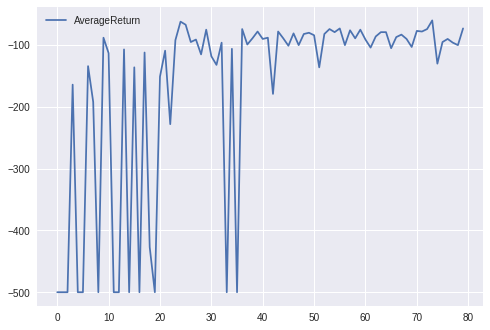

In [0]:
import os.path as osp
import numpy as np
import csv
import matplotlib.pyplot as plt
import json
import joblib
from glob import glob
import os

# mypath = './acrobot_dqn_plus/'

plots = []
legends = []
returns = []
with open(osp.join(mypath, 'progress.csv'), 'rt') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['AverageReturn']:
            returns.append(float(row['AverageReturn']))
returns = np.array(returns)
plots.append(plt.plot(returns)[0])
legends.append('AverageReturn')
plt.legend(plots, legends)
plt.show()

**4. Play Videos of your Agent Behavior**

- You can watch how your agent's behavior improves.
- If you haven't update 'mypath' in the code above, you need to update it here.
- (/content/acrobot_dqn_plus/)

In [0]:
from IPython import display as pythondisplay
# from pyvirtualdisplay import Display

# from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from matplotlib import animation
from JSAnimation import IPython_display
from IPython.display import HTML

import imageio

from os import listdir
from os.path import isfile, join

def plot_movie_js(image_array, filename):
    dpi = 10.0
    xpixels, ypixels = image_array[0].shape[0], image_array[0].shape[1]
    fig = plt.figure(figsize=(ypixels/(dpi), xpixels/(dpi)), dpi=dpi)
    fig.suptitle(filename, fontsize=160)
    # fig.set_xlabel(filename, fontsize=160)
    # fig.xlabel(filename, fontsize=160)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)
    
    anim = animation.FuncAnimation(fig, animate, frames=len(image_array))
    pythondisplay.display(IPython_display.display_animation(anim))

# mypath = './acrobot_dqn_plus/'
mypath += 'gym_log/'
mp4files = [f for f in listdir(mypath) if f.endswith(".mp4")]
mp4files.sort()


for filename in mp4files:
    vid = imageio.get_reader(join(mypath, filename),  'ffmpeg')
    # print(len(vid))
    # print(vid.get_data(0).shape)

    screenlist = []
    for i in range(len(vid)):
        image = vid.get_data(i)
        screenlist.append(image)
        # fig = plt.figure()
        # fig.suptitle('image #{}'.format(i), fontsize=20)
        # plt.imshow(image)

    plot_movie_js(screenlist, filename)
